In [24]:
import functools
import operator
import string

import joblib
import textblob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.base import BaseEstimator
from sklearn.base import TransformerMixin
from sklearn.decomposition import NMF
from sklearn.decomposition import TruncatedSVD as LSA
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS
from sklearn.pipeline import Pipeline

In [2]:
# sns.set(style="whitegrid")
sns.set(style="darkgrid")

In [3]:
X = pd.read_csv('quora_challenge.csv')

In [4]:
# the vast majority of questions are short texts
X['question_text'].str.len().describe()

count    983801.000000
mean         68.881823
std          36.746332
min           5.000000
25%          44.000000
50%          59.000000
75%          83.000000
max         752.000000
Name: question_text, dtype: float64

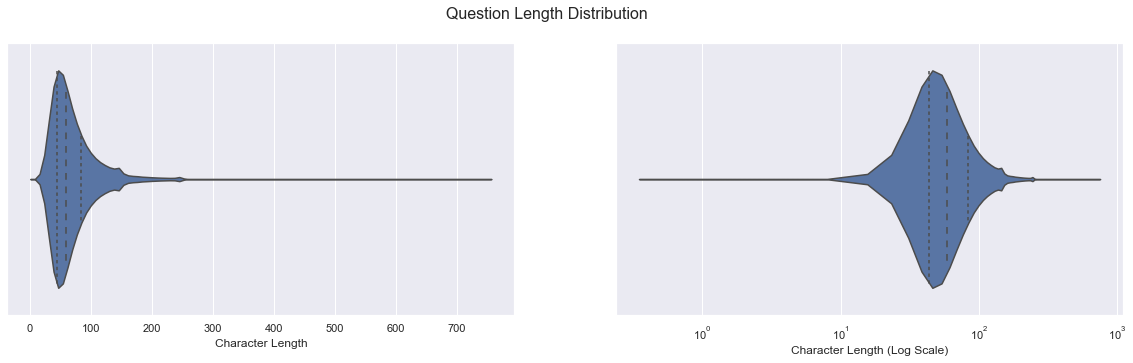

In [5]:
X['question_len'] = X['question_text'].str.len()

fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(20, 5))
fig.suptitle('Question Length Distribution', fontsize=16)

sns.violinplot(X['question_len'], inner='quartile', orient='h', ax=ax0)
ax0.set_xlabel('Character Length')

sns.violinplot(X['question_len'], inner='quartile', orient='h', ax=ax1)
ax1.set_xscale('log')
ax1.set_xlabel('Character Length (Log Scale)');

In [6]:
class TextPreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self, *, target_col='question_text', result_col='cleaned_text', pos='anvr', stop_words=None):
        self.target_col = str(target_col)
        self.result_col = str(result_col)
        self.pos = tuple(pos.lower()) if isinstance(pos, str) else tuple(pos)
        self.stop_words = () if stop_words is None else frozenset(stop_words)
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X[self.result_col] = (X[self.target_col].str.lower()
                                                .map(self.asciitize)
                                                .map(self.depunctuate)
                                                .map(self.lemmatize))
        return X[self.result_col].values
        
    @staticmethod
    def asciitize(text):
        return ''.join(char for char in text if char in string.printable)

    @staticmethod
    def depunctuate(text):
        return ''.join(char if char not in string.punctuation else ' ' for char in text)
    
    def lemmatize(self, text):
        tag_dict = dict(J='a', N='n', V='v', R='r')
        blob = textblob.TextBlob(text)
        
        try:
            words, tags = zip(*blob.pos_tags)
        except ValueError:
            return ''
        
        tags = (tag_dict.get(tag[0]) for tag in tags)
        lemmas = (word.lemmatize(tag) for word, tag in zip(words, tags)
                  if tag in self.pos
                  if word not in self.stop_words)
        result = ' '.join(lem for lem in lemmas if lem not in self.stop_words)
        return result if result else ' '

In [7]:
EXTRA_STOP_WORDS = frozenset("does doesn doesnt don dont im ive make quora really shouldnt youll ve weve wouldnt".split())
NOT_STOP_WORDS = frozenset("cry system".split())
CUSTOM_STOP_WORDS = ENGLISH_STOP_WORDS | EXTRA_STOP_WORDS - NOT_STOP_WORDS

In [73]:
vector_kwds = dict(
    ngram_range=(1, 2),
    stop_words=None,
    lowercase=False,
    max_df=0.9,
#     max_features=5_000,
    max_features=10_000,
)

decomp_kwds = dict(
    n_components=15,
    random_state=0,
)

topic_model_pipe = Pipeline([
#     ('textprep', TextPreprocessor()),
    ('vectorizer', TfidfVectorizer(**vector_kwds)),
    ('decomposer', NMF(**decomp_kwds))
], verbose=True)

In [9]:
# X_new = topic_model_pipe.fit_transform(X)
# file_prefix = '_'.join(type(step).__name__ for step in topic_model_pipe.named_steps.values()).lower()

[Pipeline] .......... (step 1 of 3) Processing textprep, total=14.6min
[Pipeline] ........ (step 2 of 3) Processing vectorizer, total=  29.5s
[Pipeline] ........ (step 3 of 3) Processing decomposer, total= 1.9min


In [ ]:
X_new = topic_model_pipe.fit_transform(X['cleaned_text'])
file_prefix = '_'.join(type(step).__name__ for step in topic_model_pipe.named_steps.values()).lower()

In [ ]:
X_new.shape

In [ ]:
joblib.dump(topic_model_pipe, f'{file_prefix}__pipeline.joblib')

In [ ]:
joblib.dump(X_new, f'{file_prefix}__X_new.joblib')

In [ ]:
# Get top words for each category -- does not need X
n_top = 8

feature_names = topic_model_pipe['vectorizer'].get_feature_names()
pyfunc = functools.partial(operator.getitem, feature_names)
vfunc = np.vectorize(pyfunc)

components = topic_model_pipe['decomposer'].components_
word_idxs = components.argsort(axis=1)[:, -n_top:][:, ::-1]
words = vfunc(word_idxs)

top_words_df = pd.DataFrame(words.T, columns=[f'Topic {i+1:0>2}' for i in range(len(words))])
top_words_df.index.name = 'Top Words'

In [ ]:
top_words_df

In [ ]:
joblib.dump(top_words_df, f'{file_prefix}__top_words.joblib')

In [ ]:
# Get topic count distribution
topics = np.argmax(X_new, axis=1)
x, y = np.vstack(np.unique(topics, return_counts=True))

plt.figure(figsize=(10, 5))
sns.barplot(x, y, palette='GnBu_d')
plt.title('Topic Distribution')
plt.xticks(ticks=range(len(x))
#            , labels=list('abcdefghijk')
          ) # <-- FIXME labels
plt.xlabel('Topic')
plt.ylabel('Frequency')
plt.savefig(f'{file_prefix}__topic_dist.png');

In [ ]:
# Get top representative sentences
n_sents = 5
repr_idxs = np.argsort(X_new, axis=0)[-n_sents:].T
repr_sents = X['question_text'].values[repr_idxs]
# repr_sents = X['cleaned_text'].values[repr_idxs]

In [ ]:
for i, sents in enumerate(repr_sents):
    print(f'Topic {i}')
    for sent in sents:
        print('\t', sent)
    print('-' * 100)

In [ ]:
joblib.dump(repr_sents, f'{file_prefix}__repr_sents.joblib')

In [ ]:
# Label sentences to their best topic
X['topic'] = np.argmax(X_new, axis=1)

joblib.dump(X, f'{file_prefix}__X_clean_topic.joblib')

In [ ]:
X

In [ ]:
# Random selected topic sents
samples = []
for i in range(topic_model_pipe['decomposer'].n_components):
    sample = X[X['topic'] == i]['question_text'].sample(5, random_state=0)
    samples.append(sample)
    print(f'Topic {i}')
    for sent in sample:
        print('\t', sent)
    print('-' * 100)

In [ ]:
joblib.dump(samples, f'{file_prefix}__samples.joblib')